# Who's the biggest tax evader?

#### Imports:

In [1]:
import plotly.plotly as py
import pandas as pd
import pycountry
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## 1. Data cleaning and preprocessing

In [2]:
# Load country codes
df_country_codes = pd.read_csv('data/countries_codes.csv', low_memory=False).set_index('COUNTRY')

In [3]:
# Load datasets
## Load panama papers datasets
pp_edges = pd.read_csv('data/panama_papers/panama_papers.edges.csv', low_memory=False)
pp_nodes_address = pd.read_csv('data/panama_papers/panama_papers.nodes.address.csv', low_memory=False)
pp_nodes_entity = pd.read_csv('data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
pp_nodes_intermediary = pd.read_csv('data/panama_papers/panama_papers.nodes.intermediary.csv', low_memory=False)
pp_nodes_officer = pd.read_csv('data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
## Load UN datasets
un_hdi_components_2014 = pd.read_csv('data/un/hdi_components.csv', low_memory=False)
un_gdp_per_capita = pd.read_csv('data/un/gdp_per_capita.csv', low_memory=False)
un_gdp_per_capita_ppp = pd.read_csv('data/un/gdp_per_capita_PPP.csv', low_memory=False)
## Load world bank datasets
wb_gini = pd.read_csv('data/world_bank/gini_index.csv', low_memory=False)
wb_income_share_20_per = pd.read_csv('data/world_bank/income_share_20_per.csv', low_memory=False)
wb_population_total = pd.read_csv('data/world_bank/population_total.csv', low_memory=False)
# TIM
wb_co2 = pd.read_excel('data/co2_emissions.xls')

In [4]:
# We only consider statistics that date from 2000 onwards
years_to_drop = list(map(str, np.arange(1960, 2000)))
wb_gini = wb_gini.drop(columns=years_to_drop)
wb_income_share_20_per = wb_income_share_20_per.drop(columns=years_to_drop)

In [5]:
# We select the rightmost value (most recent) for each row
gini_values = wb_gini.stack().groupby(level=0).last().reindex(wb_gini.index)

# Only select valid values and label other values as NaN
wb_gini['Gini'] = pd.to_numeric(gini_values, errors='coerce')

# Only select relevant columns
wb_gini = wb_gini[['Country Name', 'Country Code', 'Gini']]

In [6]:
# We select the rightmost value (most recent) for each row
income_share_20_per_values = wb_income_share_20_per.stack().groupby(level=0).last().reindex(wb_income_share_20_per.index)

# Only select valid values and label other values as NaN
wb_income_share_20_per['Income Share'] = pd.to_numeric(income_share_20_per_values, errors='coerce')

# Only select relevant columns
wb_income_share_20_per = wb_income_share_20_per[['Country Name', 'Country Code', 'Income Share']]

In [7]:
# Join UN datasets with country codes DataFrame
un_hdi_components_2014 = un_hdi_components_2014.join(df_country_codes, on='Country')
un_gdp_per_capita = un_gdp_per_capita.join(df_country_codes, on='Country')
un_gdp_per_capita_ppp = un_gdp_per_capita_ppp.join(df_country_codes, on='Country')

In [8]:
# List of UN DataFrames
un_dfs = [un_hdi_components_2014, un_gdp_per_capita, un_gdp_per_capita_ppp]

# Define dictionary containing pairs (country name: ISO country code)
countries = dict()

for country in pycountry.countries:
    countries[country.name] = country.alpha_3  

for df in un_dfs:
    nan_values = df['CODE'].isna()
    input_countries = list(df[nan_values]['Country'].values)
        
    codes = []
    for country in input_countries:
        if country in countries:
            codes.append(countries.get(country))
        else:        
            accepted = []
            str_country = str(country)
            # check if string contains either common or official country name
            for p_country in pycountry.countries:
                if p_country.name in str_country or (hasattr(p_country, 'common_name') and p_country.common_name in str_country):
                    accepted.append(p_country.alpha_3)
            if len(accepted) == 1:
                codes.append(accepted[0])
            else:
                codes.append(None)

    df.loc[nan_values, 'CODE'] = codes
    # Remove rows that were not found
    df = df[df['CODE'].notnull()]

In [9]:
pp_references_country = pp_nodes_address.groupby(['country_codes', 'countries']).size().reset_index(name='counts')

In [10]:
wb_population_2014 = wb_population_total[['Country Code', '2014']]
occurrence_pop = pp_references_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
occurrence_pop['counts_1000'] = 1000 * occurrence_pop['counts'] / occurrence_pop['2014']

In [11]:
# TIM

# We select the rightmost value (most recent) for each row
wb_co2_values = wb_co2.stack().groupby(level=0).last().reindex(wb_co2.index)

# Only select valid values and label other values as NaN
wb_co2['CO2 Emissions'] = pd.to_numeric(wb_co2_values, errors='coerce')

# Only keep most recent values for each country
wb_co2 = wb_co2[['Country Name', 'Country Code', 'CO2 Emissions']]

# Remove countries without indicator information
wb_co2 = wb_co2.dropna()

## 2. Data analysis and observations

### 2.1 Panama Papers and population

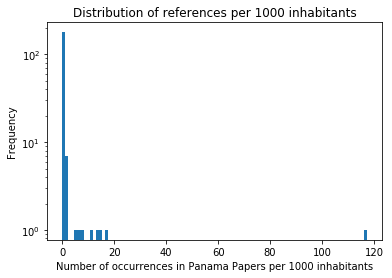

In [12]:
occurrence_pop['counts_1000'].plot.hist(title='Distribution of references per 1000 inhabitants', bins=100, logy=True)
plt.xlabel('Number of occurrences in Panama Papers per 1000 inhabitants')
plt.show()

In [13]:
pp_intermediary_country = pp_nodes_intermediary.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_intermediary_country = pp_intermediary_country.sort_values('counts', ascending=False)

We display the distribution using a map:

In [14]:
data = [ dict(
        type = 'choropleth',
        locations = pp_intermediary_country['country_codes'],
        z = pp_intermediary_country['counts'],
        text = pp_intermediary_country['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = .3
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

"""
layout = {
  "geo": {
    "coastlinewidth": 2, 
    "countrycolor": "rgb(204, 204, 204)", 
    "lakecolor": "rgb(255, 255, 255)", 
    "landcolor": "rgb(204, 204, 204)", 
    "lataxis": {
      "dtick": 10, 
      "range": [20, 60], 
      "showgrid": True
    }, 
    "lonaxis": {
      "dtick": 20, 
      "range": [-100, 20], 
      "showgrid": True
    }, 
    "projection": {"type": "equirectangular"}, 
    "resolution": 50, 
    "showlakes": True, 
    "showland": False
  }, 
  "showlegend": False, 
  "title": "Seoul to Hong Kong Great Circle"
}

"""
layout = dict(
    title = 'References in Panama Papers',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=110,
        showcoastlines = False,
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [15]:
min_count = pp_intermediary_country['counts'].min()
max_count = pp_intermediary_country['counts'].max()

In [16]:
def firstOrDefault(values, default):
    if values is None or len(values) == 0:
        return default
    return values[0]

## 3. Milestone 3

We can see from the tables that most of the countries involved in the Panama Papers affair are small islands, which unfortunately are not displayed by the `Plotly` library. For the next milestone, we will fix that issue either by finding a solution that still works with `Plotly` or by using a different library, such as `folium`.

So far, we have made insightful observations that match the reports found in the media, particularly about which countries were most involved in this affair.

For the next milestone, we will further investigate the links between the countries, and try to understand the correlation of socio-economic factors with the locations of entities, officers and intermediaries involved in Panama Papers. More specifically, we intend to:
- Find which socio-economic factors are correlated with the results we found so far, and how they are correlated
- Display the links between the countries using a graph similar to the one found [here](https://plot.ly/python/lines-on-maps/)
- Fix issues with certain countries (particularly small islands) not being displayed in the graph
-

In [17]:
pp_edges_parsed = pp_edges[['START_ID', 'TYPE', 'END_ID']]

In [18]:
pp_nodes_intermediary_parsed = pp_nodes_intermediary[['node_id', 'country_codes', 'countries']]
pp_nodes_entity_parsed = pp_nodes_entity[['node_id', 'country_codes', 'countries']]
pp_nodes_officer_parsed = pp_nodes_officer[['node_id', 'country_codes', 'countries']]

In [19]:
pp_nodes = pp_nodes_entity_parsed.append(pp_nodes_intermediary_parsed).append(pp_nodes_officer_parsed)
pp_nodes = pp_nodes.dropna()

In [20]:
pp_edges_countries = pp_nodes.merge(pp_edges_parsed, left_on='node_id', right_on='START_ID')
pp_edges_countries = pp_edges_countries.rename(columns={'node_id': 'id_origin', 'country_codes': 'cc_origin', 
                                                        'countries': 'c_origin'})
pp_edges_countries = pp_edges_countries.merge(pp_nodes, left_on='END_ID', right_on='node_id')
pp_edges_countries = pp_edges_countries.rename(columns={'node_id': 'id_dest', 'country_codes': 'cc_dest', 
                                                        'countries': 'c_dest'})
pp_edges_countries = pp_edges_countries.drop(columns=['id_origin', 'id_dest'])

## Scatter plot 

In [21]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [22]:
pp_references_country.head()

,country_codes,countries,counts
0,ABW,Aruba,18
1,AGO,Angola,38
2,AIA,Anguilla,105
3,ALB,Albania,23
4,AND,Andorra,35


In [23]:
def count_occurence(pp_data):
    return pp_data.groupby(['country_codes', 'countries']).size().reset_index(name='counts')

In [24]:
pp_references_country = count_occurence(pp_nodes_address)

In [25]:
pp_references_country.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
33,CHN,China,20267
75,HKG,Hong Kong,9147
61,GBR,United Kingdom,3996
193,VGB,British Virgin Islands,3467
155,RUS,Russia,3346


In [26]:
pp_references_officier = count_occurence(pp_nodes_officer)
pp_references_officier.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
33,CHN,China,24635
75,HKG,Hong Kong,13362
192,VGB,British Virgin Islands,11231
90,JEY,Jersey,6892
142,PAN,Panama,5069


In [27]:
pp_references_entity = count_occurence(pp_nodes_entity)
pp_references_entity.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
59,HKG,Hong Kong,37911
27,CHE,Switzerland,37911
114,PAN,Panama,15811
73,JEY,Jersey,14331
89,LUX,Luxembourg,10840


In [28]:
pp_references_intermediary = count_occurence(pp_nodes_intermediary)
pp_references_intermediary.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
91,HKG,Hong Kong,2202
75,GBR,United Kingdom,1367
28,CHE,Switzerland,1218
217,USA,United States,603
161,PAN,Panama,552


In [29]:
gdp_2015 = un_gdp_per_capita[un_gdp_per_capita['Year'] == 2015][['CODE', 'Value']]

In [30]:
gdp_2015.head()

,CODE,Value
1,AFG,610.854517
48,ALB,3877.487975
95,DZA,4160.218690
142,AND,36039.907860
189,AGO,4133.025039


In [31]:
pp_references_country.head(1)

,country_codes,countries,counts
0,ABW,Aruba,18


In [32]:
wb_population_2014.head(1)

,Country Code,2014
0,ABW,103795.0


In [33]:
nodes_types = [pp_references_country, pp_references_entity, pp_references_intermediary, pp_references_officier]

In [34]:
pp_references_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')[['country_codes', 'countries', 'counts', '2014']].head(1)

,country_codes,countries,counts,2014
0,ABW,Aruba,18,103795.0


In [35]:
def normalize_count(df):
    merged = df.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')[['country_codes', 'countries', 'counts', '2014']]
    merged['counts_normalized'] = merged['counts'] / merged['2014']
    return merged

In [36]:
nodes_types_normalized = list(map(normalize_count, nodes_types))

In [71]:
gdp_data = [x[x['counts']>0].merge(gdp_2015, left_on='country_codes', right_on='CODE') for x in nodes_types_normalized]

In [72]:
def plot_all_entity(data, x_name, y_name):
    for d in data:
        # Create a trace
        trace = go.Scatter(
            x = d[x_name],
            y = d[y_name],
            mode = 'markers',
            text = d['countries']
        )

        data = [trace]

        # Plot and embed in ipython notebook!
        iplot(data)
        print('pearson : ', d.corr())
        print('spearman : ', d.corr('spearman'))

In [73]:
plot_all_entity(gdp_data, 'counts', 'Value')

pearson :                       counts      2014  counts_normalized     Value
counts             1.000000  0.619018           0.133780  0.114575
2014               0.619018  1.000000          -0.031205 -0.068476
counts_normalized  0.133780 -0.031205           1.000000  0.176901
Value              0.114575 -0.068476           0.176901  1.000000
spearman :                       counts      2014  counts_normalized     Value
counts             1.000000  0.232621           0.598197  0.536546
2014               0.232621  1.000000          -0.578016 -0.311455
counts_normalized  0.598197 -0.578016           1.000000  0.704084
Value              0.536546 -0.311455           0.704084  1.000000


pearson :                       counts      2014  counts_normalized     Value
counts             1.000000  0.000407           0.138864  0.278906
2014               0.000407  1.000000          -0.057127 -0.094079
counts_normalized  0.138864 -0.057127           1.000000  0.651037
Value              0.278906 -0.094079           0.651037  1.000000
spearman :                       counts      2014  counts_normalized     Value
counts             1.000000  0.012956           0.756499  0.522201
2014               0.012956  1.000000          -0.601933 -0.333575
counts_normalized  0.756499 -0.601933           1.000000  0.628577
Value              0.522201 -0.333575           0.628577  1.000000


pearson :                       counts      2014  counts_normalized     Value
counts             1.000000  0.048465           0.084806  0.240342
2014               0.048465  1.000000          -0.058927 -0.109665
counts_normalized  0.084806 -0.058927           1.000000  0.715071
Value              0.240342 -0.109665           0.715071  1.000000
spearman :                       counts      2014  counts_normalized     Value
counts             1.000000  0.131410           0.585842  0.531420
2014               0.131410  1.000000          -0.682188 -0.352502
counts_normalized  0.585842 -0.682188           1.000000  0.645157
Value              0.531420 -0.352502           0.645157  1.000000


pearson :                       counts      2014  counts_normalized     Value
counts             1.000000  0.546514           0.340951  0.144035
2014               0.546514  1.000000          -0.027614 -0.068868
counts_normalized  0.340951 -0.027614           1.000000  0.127230
Value              0.144035 -0.068868           0.127230  1.000000
spearman :                       counts      2014  counts_normalized     Value
counts             1.000000  0.187441           0.635480  0.523369
2014               0.187441  1.000000          -0.575215 -0.308534
counts_normalized  0.635480 -0.575215           1.000000  0.685548
Value              0.523369 -0.308534           0.685548  1.000000


In [40]:
gini_nan = wb_gini.dropna()

In [67]:
gini_data = [x[x['counts'] > 0].merge(gini_nan, left_on='country_codes', right_on='Country Code') for x in nodes_types_normalized]

In [68]:
gini_data[0].head(2)

,country_codes,countries,counts,2014,counts_normalized,Country Name,Country Code,Gini
0,AGO,Angola,38,26920466.0,0.000001,Angola,AGO,42.7
1,ALB,Albania,23,2889104.0,0.000008,Albania,ALB,29.0


In [69]:
plot_all_entity(gini_data, 'counts_normalized', 'Gini')

pearson :                       counts      2014  counts_normalized      Gini
counts             1.000000  0.688077           0.035584  0.068329
2014               0.688077  1.000000          -0.043895  0.027535
counts_normalized  0.035584 -0.043895           1.000000  0.072960
Gini               0.068329  0.027535           0.072960  1.000000
spearman :                       counts      2014  counts_normalized      Gini
counts             1.000000  0.304864           0.692549 -0.019369
2014               0.304864  1.000000          -0.405163  0.074940
counts_normalized  0.692549 -0.405163           1.000000 -0.050621
Gini              -0.019369  0.074940          -0.050621  1.000000


pearson :                       counts      2014  counts_normalized      Gini
counts             1.000000  0.013042           0.437353 -0.017777
2014               0.013042  1.000000          -0.067389  0.023046
counts_normalized  0.437353 -0.067389           1.000000 -0.002466
Gini              -0.017777  0.023046          -0.002466  1.000000
spearman :                       counts      2014  counts_normalized      Gini
counts             1.000000  0.047999           0.840009  0.008601
2014               0.047999  1.000000          -0.453856  0.104128
counts_normalized  0.840009 -0.453856           1.000000 -0.044536
Gini               0.008601  0.104128          -0.044536  1.000000


pearson :                       counts      2014  counts_normalized      Gini
counts             1.000000  0.074864           0.323239  0.058130
2014               0.074864  1.000000          -0.068957  0.030275
counts_normalized  0.323239 -0.068957           1.000000 -0.045737
Gini               0.058130  0.030275          -0.045737  1.000000
spearman :                       counts      2014  counts_normalized      Gini
counts             1.000000  0.150125           0.697617  0.073677
2014               0.150125  1.000000          -0.551941  0.131859
counts_normalized  0.697617 -0.551941           1.000000 -0.027688
Gini               0.073677  0.131859          -0.027688  1.000000


pearson :                       counts      2014  counts_normalized      Gini
counts             1.000000  0.666306           0.073596  0.083933
2014               0.666306  1.000000          -0.043874  0.027535
counts_normalized  0.073596 -0.043874           1.000000  0.080993
Gini               0.083933  0.027535           0.080993  1.000000
spearman :                       counts      2014  counts_normalized      Gini
counts             1.000000  0.265808           0.726093 -0.001459
2014               0.265808  1.000000          -0.397410  0.074940
counts_normalized  0.726093 -0.397410           1.000000 -0.036812
Gini              -0.001459  0.074940          -0.036812  1.000000


In [44]:
len(wb_income_share_20_per)

264

In [45]:
wb_income_share_nan = wb_income_share_20_per.dropna()

In [46]:
wb_income_share_nan.head(2)

,Country Name,Country Code,Income Share
2,Angola,AGO,48.5
3,Albania,ALB,37.8


In [54]:
income_share_data = [x[x['counts'] > 0].merge(wb_income_share_nan, left_on='country_codes', right_on='Country Code') for x in nodes_types_normalized]


In [55]:
income_share_data[2].corr()

,counts,2014,counts_normalized,Income Share
counts,1.000000,0.074864,0.323239,0.034999
2014,0.074864,1.000000,-0.068957,0.040818
counts_normalized,0.323239,-0.068957,1.000000,-0.055085
Income Share,0.034999,0.040818,-0.055085,1.000000


In [56]:
plot_all_entity(income_share_data, 'counts_normalized', 'Income Share')

pearson :                       counts      2014  counts_normalized  Income Share
counts             1.000000  0.688077           0.035584      0.053509
2014               0.688077  1.000000          -0.043895      0.033179
counts_normalized  0.035584 -0.043895           1.000000      0.079081
Income Share       0.053509  0.033179           0.079081      1.000000
spearman :                       counts      2014  counts_normalized  Income Share
counts             1.000000  0.304864           0.692549     -0.043907
2014               0.304864  1.000000          -0.405163      0.095879
counts_normalized  0.692549 -0.405163           1.000000     -0.094935
Income Share      -0.043907  0.095879          -0.094935      1.000000


pearson :                       counts      2014  counts_normalized  Income Share
counts             1.000000  0.013042           0.437353     -0.029070
2014               0.013042  1.000000          -0.067389      0.030357
counts_normalized  0.437353 -0.067389           1.000000     -0.004802
Income Share      -0.029070  0.030357          -0.004802      1.000000
spearman :                       counts      2014  counts_normalized  Income Share
counts             1.000000  0.047999           0.840009     -0.013902
2014               0.047999  1.000000          -0.453856      0.122995
counts_normalized  0.840009 -0.453856           1.000000     -0.083089
Income Share      -0.013902  0.122995          -0.083089      1.000000


pearson :                       counts      2014  counts_normalized  Income Share
counts             1.000000  0.074864           0.323239      0.034999
2014               0.074864  1.000000          -0.068957      0.040818
counts_normalized  0.323239 -0.068957           1.000000     -0.055085
Income Share       0.034999  0.040818          -0.055085      1.000000
spearman :                       counts      2014  counts_normalized  Income Share
counts             1.000000  0.150125           0.697617      0.035629
2014               0.150125  1.000000          -0.551941      0.159148
counts_normalized  0.697617 -0.551941           1.000000     -0.081001
Income Share       0.035629  0.159148          -0.081001      1.000000


pearson :                       counts      2014  counts_normalized  Income Share
counts             1.000000  0.666306           0.073596      0.068002
2014               0.666306  1.000000          -0.043874      0.033179
counts_normalized  0.073596 -0.043874           1.000000      0.087071
Income Share       0.068002  0.033179           0.087071      1.000000
spearman :                       counts      2014  counts_normalized  Income Share
counts             1.000000  0.265808           0.726093     -0.023646
2014               0.265808  1.000000          -0.397410      0.095879
counts_normalized  0.726093 -0.397410           1.000000     -0.079417
Income Share      -0.023646  0.095879          -0.079417      1.000000


In [50]:
un_hdi_components_2014.head(1)

,HDI rank,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,CODE
0,1,Norway,0.944,81.6,17.5,12.6,64992,5,NOR


In [51]:
hdi_data = [x[x['counts'] > 200].merge(un_hdi_components_2014, left_on='country_codes', right_on='CODE') for x in nodes_types_normalized]


In [52]:
plot_all_entity(hdi_data, 'counts_normalized', 'Human Development Index (HDI)')

pearson :                       counts      2014  counts_normalized  HDI rank
counts             1.000000  0.608617          -0.060801 -0.032938
2014               0.608617  1.000000          -0.116914  0.239273
counts_normalized -0.060801 -0.116914           1.000000  0.159641
HDI rank          -0.032938  0.239273           0.159641  1.000000
spearman :                       counts      2014  counts_normalized  HDI rank
counts             1.000000  0.157015           0.227070 -0.174735
2014               0.157015  1.000000          -0.895245  0.107575
counts_normalized  0.227070 -0.895245           1.000000 -0.149965
HDI rank          -0.174735  0.107575          -0.149965  1.000000


pearson :                       counts      2014  counts_normalized  HDI rank
counts             1.000000 -0.037671           0.049628 -0.288721
2014              -0.037671  1.000000          -0.099022  0.092989
counts_normalized  0.049628 -0.099022           1.000000  0.320828
HDI rank          -0.288721  0.092989           0.320828  1.000000
spearman :                       counts      2014  counts_normalized  HDI rank
counts             1.000000 -0.135528           0.539080 -0.100751
2014              -0.135528  1.000000          -0.878647 -0.025864
counts_normalized  0.539080 -0.878647           1.000000 -0.023609
HDI rank          -0.100751 -0.025864          -0.023609  1.000000


pearson :                       counts      2014  counts_normalized  HDI rank
counts             1.000000 -0.256161           0.199159 -0.630916
2014              -0.256161  1.000000          -0.275139  0.219500
counts_normalized  0.199159 -0.275139           1.000000 -0.440402
HDI rank          -0.630916  0.219500          -0.440402  1.000000
spearman :                       counts      2014  counts_normalized  HDI rank
counts             1.000000 -0.076923           0.405594 -0.706294
2014              -0.076923  1.000000          -0.902098  0.223776
counts_normalized  0.405594 -0.902098           1.000000 -0.405594
HDI rank          -0.706294  0.223776          -0.405594  1.000000


pearson :                       counts      2014  counts_normalized  HDI rank
counts             1.000000  0.566800          -0.026124 -0.089870
2014               0.566800  1.000000          -0.113670  0.171164
counts_normalized -0.026124 -0.113670           1.000000  0.188985
HDI rank          -0.089870  0.171164           0.188985  1.000000
spearman :                       counts      2014  counts_normalized  HDI rank
counts             1.000000  0.077741           0.271906 -0.198138
2014               0.077741  1.000000          -0.909404  0.044798
counts_normalized  0.271906 -0.909404           1.000000 -0.079180
HDI rank          -0.198138  0.044798          -0.079180  1.000000


In [53]:
co2_data[0].head(1)

NameError: name 'co2_data' is not defined

In [ ]:
co2_data = [x[x['counts'] > 0].merge(wb_co2, left_on='country_codes', right_on='Country Code') for x in nodes_types_normalized]


In [ ]:
plot_all_entity(co2_data, 'counts', 'CO2 Emissions')

In [ ]:
pp_references_entity.hist('counts', bins=100)

In [61]:
len(pp_edges)

674102

In [62]:
len(pp_nodes_entity)

213634

In [63]:
len(pp_nodes_officer)

238402

In [64]:
len(pp_nodes_intermediary)

14110

In [65]:
len(pp_nodes_address)

93454

In [74]:
pp_nodes_entity.head()

,node_id,name,jurisdiction,jurisdiction_description,country_codes,countries,incorporation_date,inactivation_date,struck_off_date,closed_date,ibcRUC,status,company_type,service_provider,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",SAM,Samoa,HKG,Hong Kong,23-MAR-2006,18-FEB-2013,15-FEB-2013,NaN,25221,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",SAM,Samoa,HKG,Hong Kong,27-MAR-2006,27-FEB-2014,15-FEB-2014,NaN,25249,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
2,10000003,"HOTFOCUS CO., LTD.",SAM,Samoa,HKG,Hong Kong,10-JAN-2006,15-FEB-2012,15-FEB-2012,NaN,24138,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.",SAM,Samoa,HKG,Hong Kong,06-JAN-2006,16-FEB-2009,15-FEB-2009,NaN,24012,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,SAM,Samoa,HKG,Hong Kong,19-APR-2006,15-MAY-2009,15-FEB-2008,NaN,R25638,Changed agent,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
